In [1]:
# can we make the same diagram using Hipparcos?
# https://www.cosmos.esa.int/web/hipparcos/catalogue-summary

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/qthist2d')
from qthist2d import qthist, qtcount

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [4]:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/I/239
hip_file = '../data/hipparcos/I_239_hip_main.dat.fits'
hip = Table.read(hip_file, format='fits')

hvar_file = '../data/hipparcos/I_239_hip_va_1.dat.gz.fits'
hvar = Table.read(hvar_file, format='fits')

In [5]:
hvar_merge = hvar.to_pandas().merge(hip.to_pandas(), left_on='HIP', right_on='HIP')
hvar_merge['VarType'] = pd.Series(hvar['VarType']).str.decode('utf-8')

In [6]:
EBs = np.where((hvar_merge['VarType'].str.contains('EA').values | 
                hvar_merge['VarType'].str.contains('EB').values | 
                hvar_merge['VarType'].str.contains('EW').values) & 
               (hvar_merge['Plx'] > 0) & (hvar_merge['Plx'] / hvar_merge['e_Plx'] > 2) & 
               (hvar_merge['e_B-V']>0) & (hvar_merge['e_B-V']<0.25))[0]

Dok = np.where((hip['Plx']>0) & (hip['Plx'] / hip['e_Plx'] > 2) & 
               (hip['e_B-V']>0) & (hip['e_B-V']<0.25))[0]

print(len(EBs), len(hvar_merge), len(Dok), len(hip))

564 2712 88247 118218


<ipython-input-6-b53c2a8afe3b>:7: RuntimeWarning: invalid value encountered in true_divide
  Dok = np.where((hip['Plx']>0) & (hip['Plx'] / hip['e_Plx'] > 2) &


Text(0, 0.5, '$M_V$ (mag)')

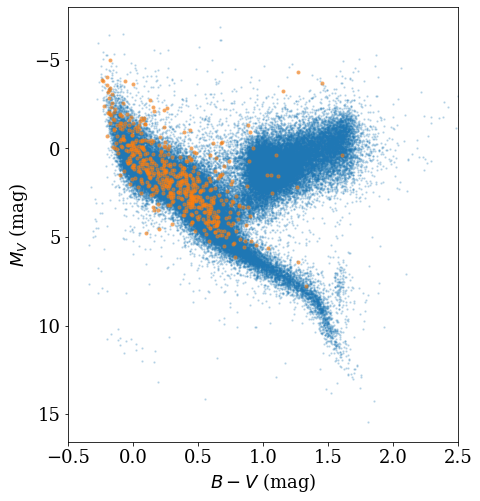

In [7]:
fig = plt.figure(figsize=(7,8))

plt.scatter(hip['B-V'][Dok], hip['Vmag'][Dok] - 5.*np.log10(1000/hip['Plx'][Dok]) + 5, 
            s=2, alpha=0.2)

plt.scatter(hvar_merge['B-V'][EBs], 
            hvar_merge['Vmag'][EBs] - 5.*np.log10(1000/hvar_merge['Plx'][EBs]) + 5, 
            s=10, alpha=0.5)

plt.gca().invert_yaxis()
plt.xlim(-0.5, 2.5)
plt.xlabel('$B-V$ (mag)')
plt.ylabel('$M_V$ (mag)')

In [8]:
# smooth both EBs and Stars w/ a 2D Gaussian KDE
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xmin=-1, xmax = 5.5, ymin= -6, ymax=16,
          xbins=100j, ybins=100j, **kwargs): 
    """
    Build a 2D kernel density estimate (KDE)
    https://stackoverflow.com/a/41639690
    """

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[xmin:xmax:xbins, 
                      ymin:ymax:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [9]:
# do the 2d KDE smoothing thing (slow)
xx2, yy2, zz2 = kde2D(hip['B-V'][Dok], hip['Vmag'][Dok] - 5.*np.log10(1000/hip['Plx'][Dok]) + 5, 
                      0.1)

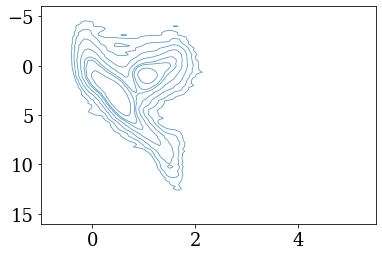

In [41]:
plt.contour(xx2, yy2, zz2/np.sum(zz2)*float(len(Dok)), 
            colors='C0', levels=(1,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)
plt.gca().invert_yaxis()

Text(0, 0.5, '$M_V$ (mag)')

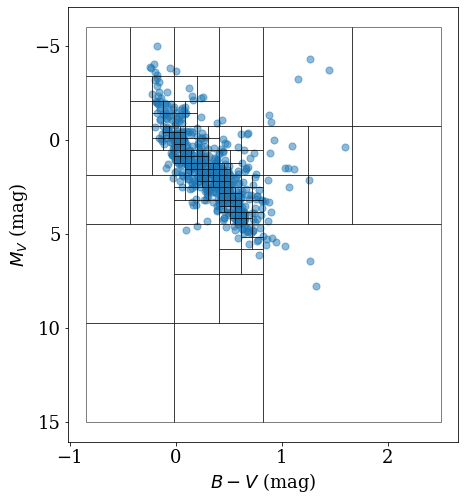

In [34]:
x=hvar_merge['B-V'][EBs]
y=hvar_merge['Vmag'][EBs] - 5.*np.log10(1000/hvar_merge['Plx'][EBs]) + 5

num, xmin, xmax, ymin, ymax = qthist(x,y, N=6, thresh=10, density=False, rng=[[-0.85,2.5],[-6,15]])

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)

plt.scatter(x,y, s=50, alpha=0.5, rasterized=True)

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', lw=1, alpha=0.5, color='k'))

plt.gca().invert_yaxis()
# plt.ylim(15.5,-6.5)

plt.xlabel('$B-V$ (mag)')
plt.ylabel('$M_V$ (mag)')

# plt.savefig('QT_bins_v2.2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [35]:
x2 = hip['B-V'][Dok]
y2 = hip['Vmag'][Dok] - 5.*np.log10(1000/hip['Plx'][Dok]) + 5

# using Quad Tree bins defined from EB sample, count the background sample
num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=False)

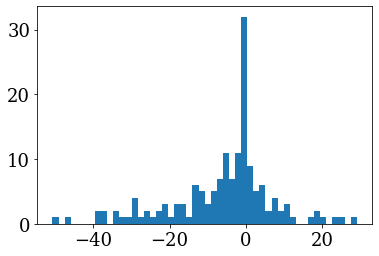

In [36]:
def EBscore(num, num2, xmin, xmax, ymin, ymax):
    '''
    compute the Eclipsing Binary rarity score
    assumes the number counts in each bin are NOT densities
    '''
    areas = np.abs(ymax - ymin) * np.abs(xmax - xmin)
    d_EB = num / areas / num.sum() + 1
    d_bk = num2 / areas / num2.sum() + 1
    SCORE = 1 - (d_EB/d_bk)
    return SCORE*100

SCORE = EBscore(num, num2, xmin,xmax,ymin,ymax)
_ = plt.hist(SCORE,bins=50)

Text(0.5, 1.0, 'Hipparcos EBs')

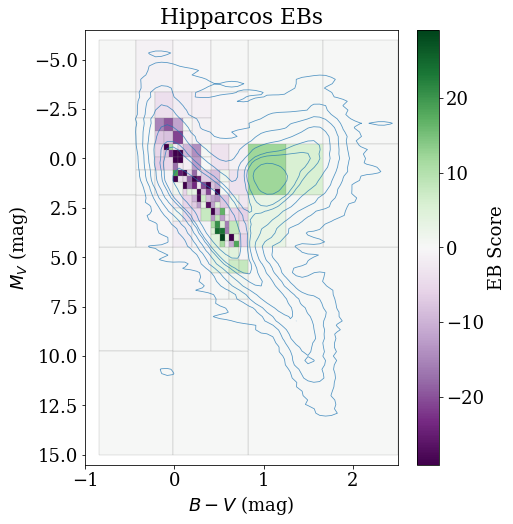

In [40]:
# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)
    
# SCORE[SCORE > 25] = 25
# SCORE[SCORE < -25] = -25
    
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn

# if doing the 2d Histogram for background (fast, but ratty)
# plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
#             zz2.T / np.sum(zz2)*float(len(Dok)), colors='C0', alpha=0.5, 
#             levels=(3,10,100,500))

# if doing the 2d KDE (slow, but smoother) for background illustration
plt.contour(xx2, yy2, zz2/np.sum(zz2)*float(len(Dok)), 
            colors='C0', levels=(.5,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('EB Score')


plt.gca().invert_yaxis()
plt.xlabel('$B-V$ (mag)')
plt.ylabel('$M_V$ (mag)')

# plt.xlim(min(x), max(x))
# plt.ylim(max(y), min(y))
plt.ylim(15.5,-6.5)
plt.xlim(-1,2.5)
plt.title('Hipparcos EBs')
plt.savefig('Hipparcos_score.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)